# Time Series Similarity search with aeon

The goal of Time Series Similarity search is to asses the similarities between a time series, denoted as a query `q` of length `l`, and a collection of time series, denoted as `X`, which lengths are superior or equal to `l`. In this context, the notion of similiarity between `q` and the other series in `X` is quantified by similarity functions. Those functions are most of the time defined as distance function, such as the Euclidean distance. Knowing the similarity between `q` and other admissible candidates, we can then perform many other tasks for "free", such as anomaly or motif detection.

<img src="img/sim_search.png" width="600" alt="time series similarity search">

## Similarity search Notebooks

This notebook gives an overview of similarity search module and the available estimators. The following notebooks are avaiable to go more in depth with specific subject of similarity search in aeon:

- [Deep dive in the distance profiles](distance_profiles.ipynb)
- [Analysis of the speedups provided by similarity search module](code_speed.ipynb)

## Expected inputs and format


## Available estimators

All estimators of the similarity search module in aeon inherit from the `BaseSimilaritySearch` class, which requires the following arguments:
- `distance` : a string indicating which distance function to use as similarity function. By default this is `"euclidean"`, which means that the Euclidean distance is used.
- `normalize` : a boolean indicating whether this similarity function should be z-normalized. This means that the scale of the two series being compared will be ignored, and that, loosely speaking, we will only focus on their shape during the comparison. By default, this parameter is set `False`.

Another parameter, which has no effect on the output of the estimators, is a boolean named `store_distance_profile`, set to `False` by default. If set to `True`, the estimators will expose an attribute named `_distance_profile` after the `predict` function is called. This attribute will contain the computed distance profile for query given as input to the `predict` function.

To illustrate how to work with similarity search estimators in aeon, we will now present some example use cases.

### Top-K similarity search

We will use the GunPoint dataset for this example, which can be loaded using the `load_classification` function.

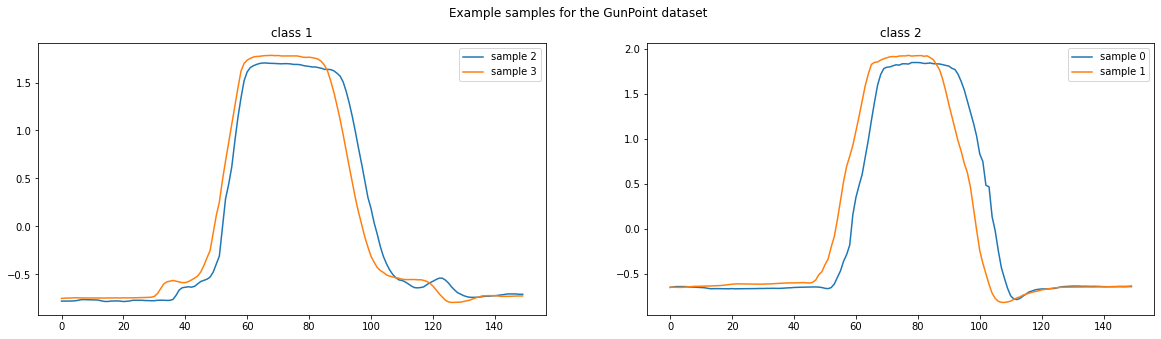

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from aeon.datasets import load_classification

# Load GunPoint dataset
X, y = load_classification("GunPoint")

classes = np.unique(y)

fig, ax = plt.subplots(figsize=(20, 5), ncols=len(classes))
for i_class, _class in enumerate(classes):
    for i_x in np.where(y == _class)[0][0:2]:
        ax[i_class].plot(X[i_x, 0], label=f"sample {i_x}")
    ax[i_class].legend()
    ax[i_class].set_title(f"class {_class}")
plt.suptitle("Example samples for the GunPoint dataset")
plt.show()

The GunPoint dataset is composed of two classes which are discriminated by the "bumps" located before and after the central peak. These bumps correspond to an actor drawing a fake gun from a holster before pointing it (hence the name "GunPoint" !). In the second class, the actor simply points his fingers without making the motion of taking the gun out of the holster.

Suppose that we define our input query for the similarity search task as one of these bumps:

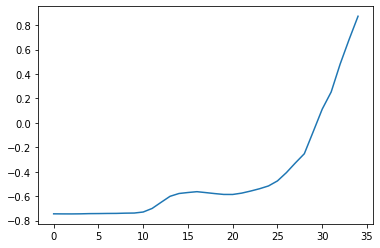

In [2]:
q = X[3, :, 20:55]
plt.plot(q[0])
plt.show()

Then, we can use the `TopKSimilaritySearch` class to search for the top `k` matches of this query in a collection of series. The training data for `TopKSimilaritySearch` can be seen as the database in which want to search for the query on.

In [3]:
from aeon.similarity_search import TopKSimilaritySearch

# Here, the distance function (distance and normalize arguments)
top_k_search = TopKSimilaritySearch(k=3, distance="euclidean")

mask = np.ones(X.shape[0], dtype=bool)
mask[3] = False
# Use this mask to exluce the sample from which we extracted the query
X_train = X[mask]
# Call fit to store X_train as the database to search in
top_k_search.fit(X_train)
best_matches = top_k_search.predict(q)
print(best_matches)

[[195  26]
 [ 92  23]
 [154  22]]


The similarity search estimators return a list of size `k`, which contains a tuple containing the location of the best matches as `(id_sample, id_timestamp)`. We can then plot the results as:

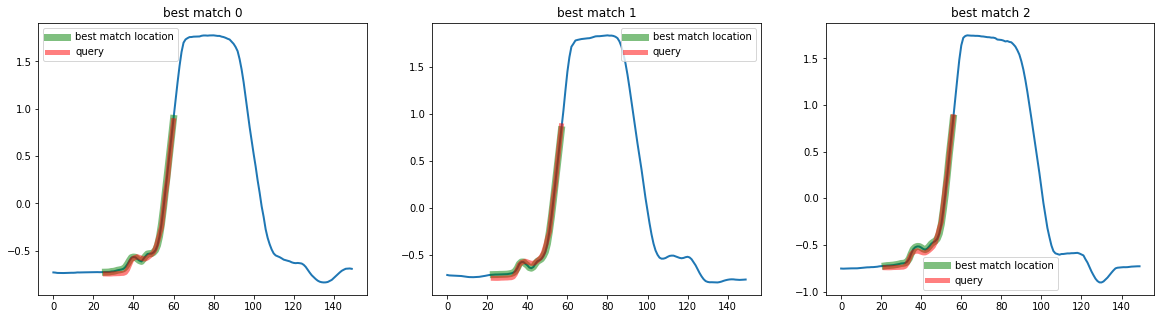

In [4]:
fig, ax = plt.subplots(figsize=(20, 5), ncols=3)
for i_k, (id_sample, id_timestamp) in enumerate(best_matches):
    # plot the sample of the best match
    ax[i_k].plot(top_k_search._X[id_sample, 0], linewidth=2)
    # plot the location of the best match on it
    ax[i_k].plot(
        range(id_timestamp, id_timestamp + q.shape[1]),
        top_k_search._X[id_sample, 0, id_timestamp : id_timestamp + q.shape[1]],
        linewidth=7,
        alpha=0.5,
        color="green",
        label="best match location",
    )
    # plot the query on the location of the best match
    ax[i_k].plot(
        range(id_timestamp, id_timestamp + q.shape[1]),
        q[0],
        linewidth=5,
        alpha=0.5,
        color="red",
        label="query",
    )
    ax[i_k].set_title(f"best match {i_k}")
    ax[i_k].legend()
plt.show()

## Using the speed_up option for similarity search

In the similarity search module, we implement different kind of optimization to decrease the time necessary to extract the best matches to a query. You can find more information about these optimization in the other notebooks of the similarity search module. An utility function is available to list the optimizations currently implemented in aeon :  

In [5]:
from aeon.similarity_search import get_speedup_function_names

get_speedup_function_names()

{'normalized euclidean': ['ConvolveDotProduct'],
 'euclidean': ['ConvolveDotProduct'],
 'normalized squared': ['ConvolveDotProduct'],
 'squared': ['ConvolveDotProduct']}

Then, you can use these values with the corresponding distance function and normalization options in the estimators of the similarity search module as follows:

In [6]:
top_k_search = TopKSimilaritySearch(
    distance="euclidean", normalize=True, speed_up="ConvolveDotProduct"
)